# Analytical Backbone 1 - Rental Affordability 📊

This analysis evaluates housing affordability in Barcelona by examining the relationship between rental prices, income inequality, and social equity. The Rent-to-Income Ratio, serves as the primary metric for identifying affordability challenges. To further highlight areas of stress, we define the Economic Stress Score that is slightly more accurate for taking inequality into account due to its relation with gini index.

Economically stressed or high ratio areas will be highligthed, supported by dashboards featuring heatmaps of affordability and comparative plots of rent and income. Unsupervised techniques like clustering and PCA help reveal hidden patterns in housing inequities.



# 1. Initial steps


## 1.1 Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import os
from google.colab import drive


drive.mount('/content/drive')

import matplotlib.pyplot as plt


#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway, chi2_contingency


import warnings
warnings.filterwarnings('ignore')

from shapely import wkt

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


2025-01-05 08:58:26.420 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## 1.2 Define Data Loader

In [2]:
class DuckDBManager:
    """
    A class to manage a DuckDB database within a specified project directory structure.
    """

    def __init__(self, path):
        """
        Initializes the DuckDBManager with a specified base path.

        Args:
            path (str): Path of the main project directory.

        Raises:
            ValueError: If the path does not exist or is not a directory.
        """
        if not os.path.exists(path) or not os.path.isdir(path):
            raise ValueError(f"Provided path '{path}' is invalid or does not exist.")

        self.base_path = path
        self.landing_persistent_path = self.base_path + '/landing_zone/persistent'
        self.formatted_zone_path = self.base_path + '/formatted_zone'
        self.db_path = self.formatted_zone_path + '/formatted_zone.duckdb'
        self.trusted_zone_path = self.base_path + '/trusted_zone'
        self.trusted_db_path = self.trusted_zone_path + '/trusted_zone.duckdb'
        self.exploitation_zone_path = self.base_path + '/exploitation_zone'
        self.exploitation_db_path = self.exploitation_zone_path + '/exploitation_zone.duckdb'
        self.analytical_sandbox_path = self.base_path + '/analytical_sandbox'
        self.analytical_sandbox_db_path = self.analytical_sandbox_path + '/analytical_sandbox.duckdb'
        self.feature_engineering_path = self.base_path + '/feature_engineering'
        self.feature_generation_db_path = self.feature_engineering_path + '/feature_generation.duckdb'
        self.data_preparation_db_path = self.feature_engineering_path + '/data_preparation.duckdb'
        self.labeling_db_path = self.feature_engineering_path + '/labeling.duckdb'
        self.train_test_db_path = self.feature_engineering_path + '/train_test.duckdb'

        self.analytical_backbone_1_path = self.base_path + '/analytical_backbone_1'
        self.analytical_backbone_2_path = self.base_path + '/analytical_backbone_2'

        os.makedirs(self.landing_persistent_path, exist_ok=True)
        os.makedirs(self.formatted_zone_path, exist_ok=True)
        os.makedirs(self.trusted_zone_path, exist_ok=True)
        os.makedirs(self.exploitation_zone_path, exist_ok=True)

    def set_up_duck_db(self):
        """
        Connects to an existing DuckDB database in the formatted zone directory
        or creates one if it does not exist.

        Returns:
            con (duckdb.DuckDBPyConnection): Connection object for the DuckDB database.
        """
        con = duckdb.connect(self.db_path)
        print(f"Connected to DuckDB database at '{self.db_path}'.")
        return con

    def list_tables(self, con):
        """
        Lists all tables in the DuckDB database.

        Args:
            con (duckdb.DuckDBPyConnection): Connection object to the DuckDB database.

        Returns:
            list: List of table names in the database.
        """
        try:
            tables = con.execute("SHOW TABLES").fetchall()
            table_names = [table[0] for table in tables]
            return table_names
        except Exception as e:
            print(f"Failed to list tables: {e}")
            raise

    def create_tables_from_csv(self, con):
        """
        Creates tables in the DuckDB database for each CSV file found in the data source folders.
        Raises an error if a table already exists with the same name.

        Args:
            con (duckdb.DuckDBPyConnection): Connection object to the DuckDB database.

        Raises:
            FileNotFoundError: If no CSV files are found in the landing zone.
            RuntimeError: If a table already exists with the same name.
        """
        try:
            # Get all existing tables to prevent overwriting
            existing_tables = self.list_tables(con)

            data_source_folders = glob.glob(os.path.join(self.landing_persistent_path, '*'))
            if not data_source_folders:
                raise FileNotFoundError("No data source folders found in the persistent landing zone.")

            for data_source_folder in data_source_folders:
                if not os.path.isdir(data_source_folder):
                    continue

                csv_files = glob.glob(os.path.join(data_source_folder, '*.csv'))
                if not csv_files:
                    print(f"No CSV files found in data source folder '{data_source_folder}'.")
                    continue

                for file_path in csv_files:
                    table_name = os.path.splitext(os.path.basename(file_path))[0]
                    if table_name in existing_tables:
                        print(f"Table '{table_name}' already exists in the database.")
                        continue

                    con.execute(f"""
                        CREATE TABLE {table_name} AS
                        SELECT * FROM read_csv_auto('{file_path}')
                    """)
                    print(f"Table '{table_name}' created successfully from '{file_path}'.")

        except FileNotFoundError as fnf_error:
            print(fnf_error)
            raise
        except RuntimeError as re:
            print(re)
            raise
        except Exception as e:
            print(f"Failed to create tables from CSV files: {e}")
            raise

    def delete_all_tables(self, con):
        """
        Deletes all tables in the DuckDB database connection.

        Args:
            con (duckdb.DuckDBPyConnection): Connection object to the DuckDB database.
        """
        try:
            tables = con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted successfully.")
            print("All tables deleted successfully.")
        except Exception as e:
            print(f"Failed to delete all tables: {e}")
            raise

    def delete_database(self):
        """
        Deletes the entire DuckDB database file from the formatted zone.

        Raises:
            FileNotFoundError: If the database file does not exist.
        """
        try:
            if os.path.exists(self.db_path):
                os.remove(self.db_path)
                print(f"DuckDB database at '{self.db_path}' deleted successfully.")
            else:
                raise FileNotFoundError(f"DuckDB database at '{self.db_path}' does not exist.")
        except Exception as e:
            print(f"Failed to delete the DuckDB database: {e}")
            raise

    # TRUSTED ZONE FUNCTIONS--------------------------------------------------------------------

    def set_up_trusted_db(self):
        """
        Sets up the trusted DuckDB database.
        """
        trusted_con = duckdb.connect(self.trusted_db_path)
        print(f"Connected to trusted DuckDB database at '{self.trusted_db_path}'.")
        return trusted_con

    def unify_tables_by_dataset(self):
        """
        Unifies tables from the formatted database into a single table per dataset in the trusted database.
        """
        con = self.set_up_duck_db()  # Connect to the formatted database
        trusted_con = self.set_up_trusted_db()  # Connect to the trusted database

        table_names = self.list_tables(con)
        dataset_tables = {}

        # Group tables by dataset name (ignore year)
        for table_name in table_names:
            dataset_name = re.sub(r'_\d{4}', '', table_name)  # Remove year to get the dataset name
            if dataset_name not in dataset_tables:
                dataset_tables[dataset_name] = []
            dataset_tables[dataset_name].append(table_name)

        # Merge tables for each dataset
        for dataset_name, tables in dataset_tables.items():
            # Combine all tables for the dataset
            dataframes = [con.execute(f"SELECT * FROM {table}").fetchdf() for table in tables]
            combined_df = pd.concat(dataframes, ignore_index=True)

            #obtain the name of the new table as the data source name
            dataset_name = tables[0].split('_')[0]

            # Save to the trusted database
            trusted_con.execute(f"CREATE TABLE {dataset_name} AS SELECT * FROM combined_df")
            print(f"Unified table '{dataset_name}' created in the trusted zone with data from {len(tables)} years.")

        # Close both connections
        con.close()
        trusted_con.close()

    def delete_all_trusted_tables(self):
        """
        Deletes all tables in the trusted DuckDB database.
        """
        trusted_con = self.set_up_trusted_db()
        try:
            tables = trusted_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                trusted_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the trusted zone.")
            print("All tables deleted from the trusted zone.")
        finally:
            trusted_con.close()

    # EXPLOITATION ZONE FUNCTIONS---------------------------------------------

    def set_up_exploitation_db(self):
        """
        Sets up the exploitation zone DuckDB database.
        """
        exploitation_db = duckdb.connect(self.exploitation_db_path)
        print(f"Connected to trusted DuckDB database at '{self.exploitation_db_path}'.")
        return exploitation_db

    def delete_all_exploitation_tables(self):
        """
        Deletes all tables in the exploitation zone DuckDB database.
        """

        exploitation_con = self.set_up_exploitation_db()
        try:
            tables = exploitation_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                exploitation_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the exploitation zone.")
            print("All tables deleted from the exploitation zone.")
        finally:
            return exploitation_con

    # ANALYTICAL SANDBOX FUNCTIONS -------------------------------------------

    def set_up_analytical_sandbox_db(self):
        """
        Sets up the analytical sandbox DuckDB database.
        """
        analytical_sandbox_db = duckdb.connect(self.analytical_sandbox_db_path)
        print(f"Connected to analytical sandbox DuckDB database at '{self.analytical_sandbox_db_path}'.")
        return analytical_sandbox_db

    def delete_all_analytical_sandbox_tables(self):
        """
        Deletes all tables in the analytical sandbox DuckDB database.
        """
        analytical_sandbox_con = self.set_up_analytical_sandbox_db()
        try:
            tables = analytical_sandbox_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                analytical_sandbox_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the analytical sandbox.")
            print("All tables deleted from the analytical sandbox.")
            print("Remaining tables in the analytical sandbox:")
            remaining_tables = analytical_sandbox_con.execute("SHOW TABLES").fetchall()
            for table in remaining_tables:
                print(table[0])
        finally:
            return analytical_sandbox_con

    # FEATURE GENERATION FUNCTIONS -------------------------------------------
    def set_up_feature_generation_db(self):
        """
        Sets up the feature generation DuckDB database.
        """
        feature_generation_db = duckdb.connect(self.feature_generation_db_path)
        print(f"Connected to feature generation DuckDB database at '{self.feature_generation_db_path}'.")
        return feature_generation_db

    def delete_all_feature_generation_tables(self):
      """
      Deletes all tables in the feature generation DuckDB database.
      """
      feature_generation_con = self.set_up_feature_generation_db()
      try:
          tables = feature_generation_con.execute("SHOW TABLES").fetchall()
          for table in tables:
              table_name = table[0]
              feature_generation_con.execute(f"DROP TABLE IF EXISTS {table_name}")
              print(f"Table '{table_name}' deleted from the feature generation.")
          print("All tables deleted from the feature generation.")
          print("Remaining tables in the feature generation:")
          remaining_tables = feature_generation_con.execute("SHOW TABLES").fetchall()
          for table in remaining_tables:
              print(table[0])
      finally:
          return feature_generation_con

    # DATA PREPARATION FUNCTIONS -------------------------------------------
    def set_up_data_preparation_db(self):
        """
        Sets up the data preparation DuckDB database.
        """
        data_preparation_db = duckdb.connect(self.data_preparation_db_path)
        print(f"Connected to data preparation DuckDB database at '{self.data_preparation_db_path}'.")
        return data_preparation_db
    def delete_all_data_preparation_tables(self):
        """
        Deletes all tables in the data preparation DuckDB database.
        """
        data_preparation_con = self.set_up_data_preparation_db()
        try:
            tables = data_preparation_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                data_preparation_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the data preparation.")
            print("All tables deleted from the data preparation.")
            print("Remaining tables in the data preparation:")
            remaining_tables = data_preparation_con.execute("SHOW TABLES").fetchall()
            for table in remaining_tables:
                print(table[0])
        finally:
            return data_preparation_con

    # LABELING FUNCTIONS -------------------------------------------
    def set_up_labeling_db(self):
        """
        Sets up the labeling DuckDB database.
        """
        labeling_db = duckdb.connect(self.labeling_db_path)
        print(f"Connected to labeling DuckDB database at '{self.labeling_db_path}'.")
        return labeling_db

    def delete_all_labeling_tables(self):
        """
        Deletes all tables in the labeling DuckDB database.
        """
        labeling_con = self.set_up_labeling_db()
        try:
            tables = labeling_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                labeling_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the labeling.")
            print("All tables deleted from the labeling.")
            print("Remaining tables in the labeling:")
            remaining_tables = labeling_con.execute("SHOW TABLES").fetchall()
            for table in remaining_tables:
                print(table[0])
        finally:
            return labeling_con


    # TRAIN TEST SPLIT FUNCTIONS -------------------------------------------
    def set_up_train_test_db(self):
        """
        Sets up the train test DuckDB database.
        """
        train_test_db = duckdb.connect(self.train_test_db_path)
        print(f"Connected to train test DuckDB database at '{self.train_test_db_path}'.")
        return train_test_db

    def delete_all_train_test_tables(self):
        """
        Deletes all tables in the train test DuckDB database.
        """
        train_test_con = self.set_up_train_test_db()
        try:
            tables = train_test_con.execute("SHOW TABLES").fetchall()
            for table in tables:
                table_name = table[0]
                train_test_con.execute(f"DROP TABLE IF EXISTS {table_name}")
                print(f"Table '{table_name}' deleted from the train test.")
            print("All tables deleted from the train test.")
            print("Remaining tables in the train test:")
            remaining_tables = train_test_con.execute("SHOW TABLES").fetchall()
            for table in remaining_tables:
                print(table[0])
        finally:
            return train_test_con

    # ANALYTICAL BACKBONE 1 FUNCTIONS -------------------------------------------
    def set_up_analytical_backbone_1_db(self):
        """
        Sets up the analytical backbone 1 DuckDB database.
        """
        analytical_backbone_1_db = duckdb.connect(self.analytical_backbone_1_path)
        print(f"Connected to analytical backbone 1 DuckDB database at '{self.analytical_backbone_1_path}'.")
        return analytical_backbone_1_db
    def delete_all_analytical_backbone_1_db(self):
      """
      Deletes all tables in the train test DuckDB database.
      """
      analytical_backbone_1_con = self.set_up_analytical_backbone_1_db()
      try:
          tables = analytical_backbone_1_con.execute("SHOW TABLES").fetchall()
          for table in tables:
              table_name = table[0]
              analytical_backbone_1_con.execute(f"DROP TABLE IF EXISTS {table_name}")
              print(f"Table '{table_name}' deleted from the analytical backbone 1.")
          print("All tables deleted from the analytical backbone 1.")
          print("Remaining tables in the analytical backbone 1:")
          remaining_tables = analytical_backbone_1_con.execute("SHOW TABLES").fetchall()
          for table in remaining_tables:
              print(table[0])
      finally:
          return analytical_backbone_1_con


    # ANALYTICAL BACKBONE 2 FUNCTIONS -------------------------------------------
    def set_up_analytical_backbone_2_db(self):
        """
        Sets up the analytical backbone 2 DuckDB database.
        """
        analytical_backbone_2_db = duckdb.connect(self.analytical_backbone_2_path)
        print(f"Connected to analytical backbone 2 DuckDB database at '{self.analytical_backbone_2_path}'.")
        return analytical_backbone_2_db

    def delete_all_analytical_backbone_2_db(self):
      """
      Deletes all tables in the analytical backbone 2 DuckDB database.
      """
      analytical_backbone_2_con = self.set_up_analytical_backbone_2_db()
      try:
          tables = analytical_backbone_2_con.execute("SHOW TABLES").fetchall()
          for table in tables:
              table_name = table[0]
              analytical_backbone_2_con.execute(f"DROP TABLE IF EXISTS {table_name}")
              print(f"Table '{table_name}' deleted from the analytical backbone 2.")
          print("All tables deleted from the analytical backbone 2.")
          print("Remaining tables in the analytical backbone 2:")
          remaining_tables = analytical_backbone_2_con.execute("SHOW TABLES").fetchall()
          for table in remaining_tables:
              print(table[0])
      finally:
          return analytical_backbone_2_con







## 1.3 Load Data

In [3]:
manager = DuckDBManager("drive/MyDrive/Assignatures/ADSDB")
data_con = manager.set_up_train_test_db()
df = data_con.execute(f"SELECT * FROM UnifiedDataBasic").fetchdf()
#Drop unnecessary variables

#Only numerical variables
numeric_df = df[["Any", "Import_Renda_Disponible", "Import_Renda_Bruta", "Import_Renda_Neta", "Index_Gini", "Distribucio_P80_20", "Edat_Mitjana", "Preu_mitja", "Recompte", "Preu_mitja_Anual", "Ratio_Lloguer_Renda", "Estres_Economic", "Lloguer_Historic_mitja"]]
numeric_df

#Numerical not artificially created data
corr_df = df[["Any", "Import_Renda_Disponible", "Import_Renda_Bruta", "Import_Renda_Neta", "Index_Gini", "Distribucio_P80_20", "Edat_Mitjana", "Preu_mitja", "Recompte"]]


Connected to train test DuckDB database at 'drive/MyDrive/Assignatures/ADSDB/feature_engineering/train_test.duckdb'.


# 2. Descriptive Analysis

To tackle the pressing issue of housing affordability in Barcelona, it is essential to conduct a comprehensive exploration of the available data. This exploratory data analysis (EDA) aims to provide a detailed understanding of the housing situation at the neighborhood level, using the "Nom_Barri" (Neighborhood) granularity. The primary objective is to derive meaningful insights into affordability, economic stress, and inequality across neighborhoods. Key questions guiding this analysis include:

Which neighborhoods are the most affordable? Which are the least affordable?
Which neighborhoods experience the greatest economic stress, paying the highest rent relative to their incomes?
Which neighborhoods exhibit the highest levels of inequality?
What proportion of neighborhoods in Barcelona can be classified as economically stressed?
This descriptive analysis will be structured into distinct sections, each focusing on a specific aspect of the data:

Relationships between key variables.
Additional insights into rent-to-income ratios, inequality, and stress factors (to be expanded).

> Note: The unified dataset does not include information for every neighborhood in Barcelona. Due to limitations in the available Open Data sources, the analysis is constrained to 53 out of 74 neighborhoods. As a result, this exploration may not fully represent all neighborhoods, making this a potential area for improvement in future iterations of the project.


## 2.1 Variables relations

Excluding our artificially generated variables, its clear that there is a strong correlation between the 3 income kinds and also a strong correlation between rent (Preu_mitja) and incomes. Another easy insight to gather is that the average age is mildly correlated with the income, thus midly inversely correlated with Gini Index and 80/20 Distribution variable. Finally, the count of rents per neighborhood (Recompte) is also mildly positively correlated with Preu_Mitja, Gini_Index and Income.

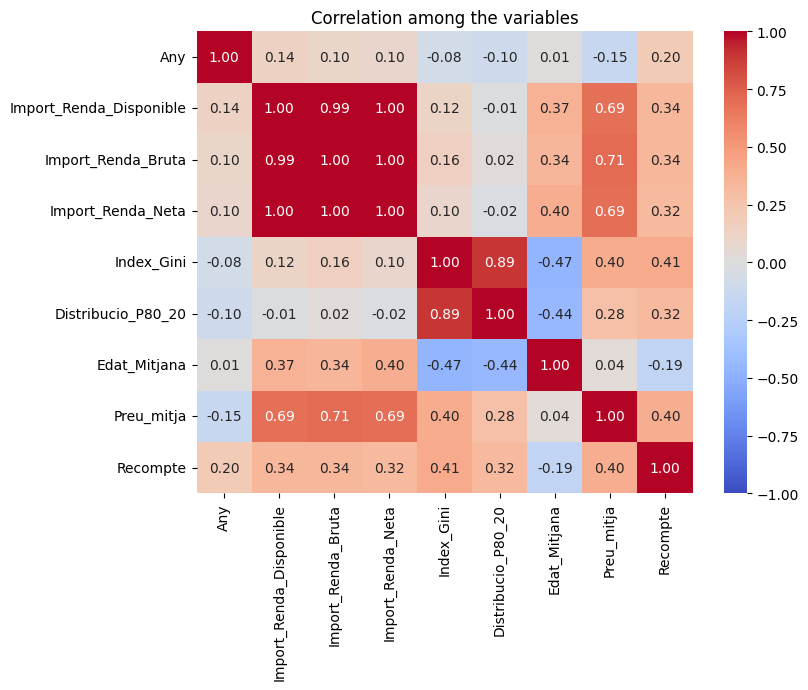

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title("Correlation among the variables")
plt.show()

## 2.2 Most affordable and Least Affordable Neighborhoods

In this section we can easily recognise the most and least affordable neighborhoods in their respective top 10 ranking followed by the aggrupation of how many censal code areas are economically stressed by each neighborhood. **For more insights this section should be contrasted with the next 2.3 section** in order to acquire familiarity with the most stressed areas in comparison to the most expensive/cheapest ones, which at first glance may seem equivalent but they in fact aren't! Not so expensive areas can be much more stressed than wealthy neighborhoods, due to various factors (People are living above their possibilities, there is economic stagnation in certain neighborhoods...)

This plots confirm the intuition of many residents of barcelona, the top 3 cheapest neighborhoods to live are *Torre Baró*, *Ciutat Meridiana* and *Baró de Viver*. In contrast, the 3 most expensive are *Vila Olimpica de Poblenou*, *Les Corts* and *Diagonal Mar i Front maritim de Poblenou*. Despite the last 3 being the most expensive they have really low count of Economically stressed censal areas. This can be due to a wide variety of reasons, but mainly that despite the rental affordability being low, the average income of those areas must be high.

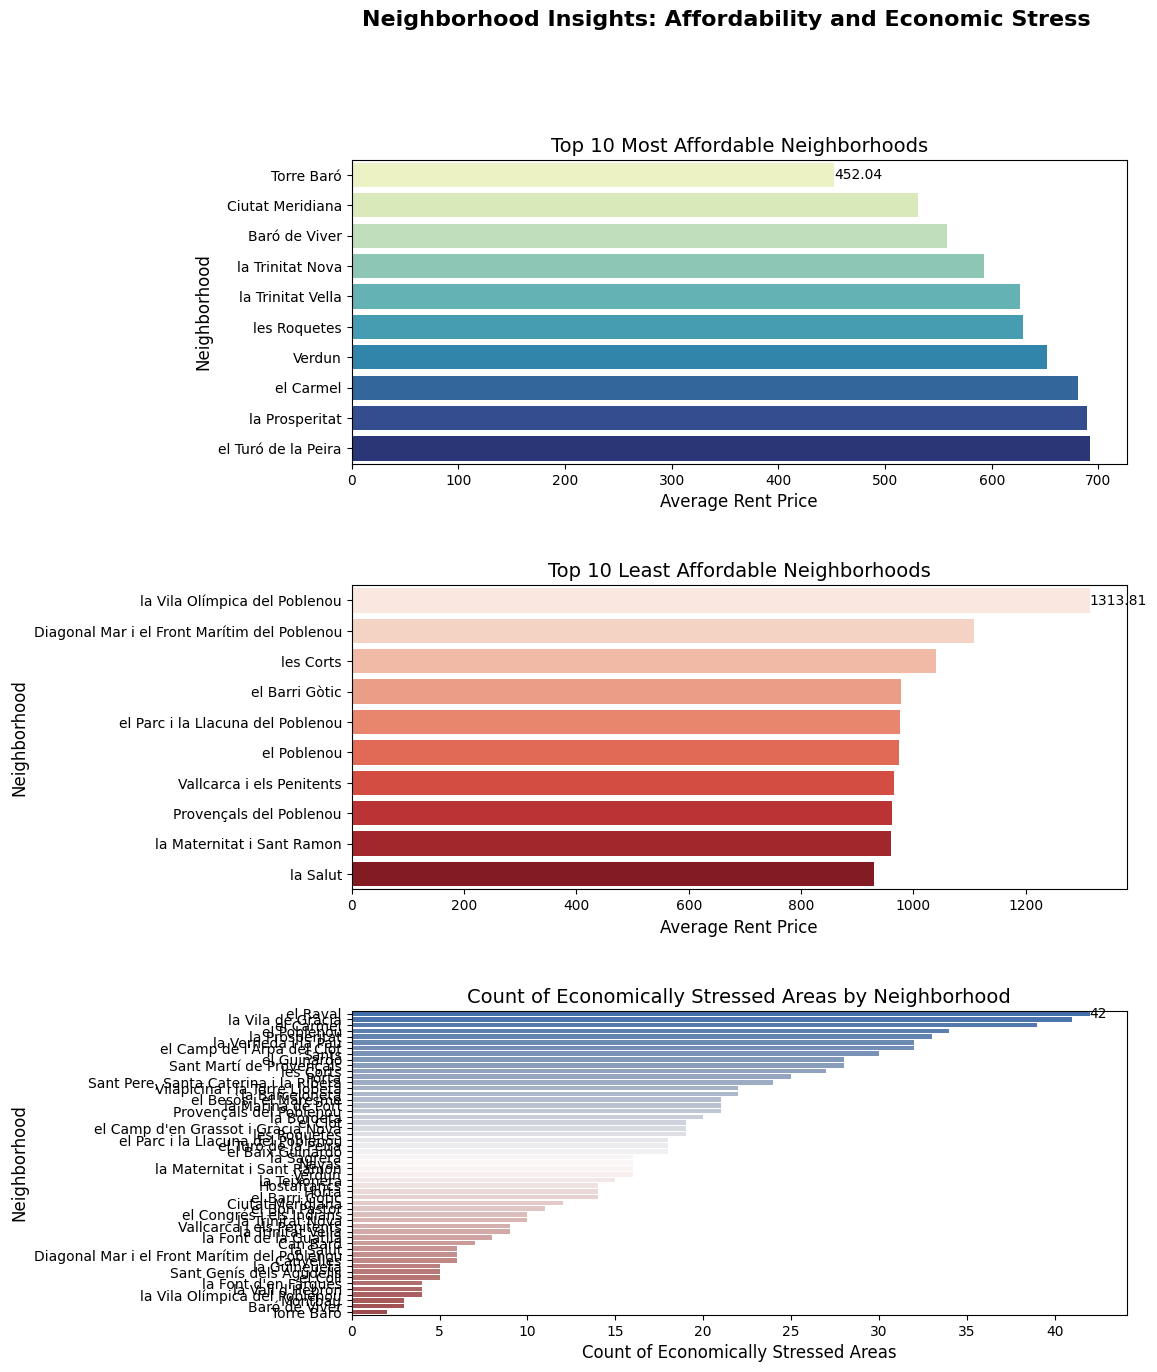

In [5]:
top_10_affordable = df.groupby("Nom_Barri")['Preu_mitja'].mean().nsmallest(10)
top_10_least_affordable = df.groupby("Nom_Barri")['Preu_mitja'].mean().nlargest(10)
stress_by_neighborhood = df[df['Factor_Estres'] == 'High']['Nom_Barri'].value_counts()

# Set up the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False, gridspec_kw={'hspace': 0.4})

# Subplot 1: Top 10 Most Affordable Neighborhoods
sns.barplot(
    x=top_10_affordable.values,
    y=top_10_affordable.index,
    palette="YlGnBu",
    ax=axes[0]
)
axes[0].set_title("Top 10 Most Affordable Neighborhoods", fontsize=14)
axes[0].set_xlabel("Average Rent Price", fontsize=12)
axes[0].set_ylabel("Neighborhood", fontsize=12)
axes[0].bar_label(axes[0].containers[0], fmt="%.2f")

# Subplot 2: Top 10 Least Affordable Neighborhoods
sns.barplot(
    x=top_10_least_affordable.values,
    y=top_10_least_affordable.index,
    palette="Reds",
    ax=axes[1]
)
axes[1].set_title("Top 10 Least Affordable Neighborhoods", fontsize=14)
axes[1].set_xlabel("Average Rent Price", fontsize=12)
axes[1].set_ylabel("Neighborhood", fontsize=12)
axes[1].bar_label(axes[1].containers[0], fmt="%.2f")

# Subplot 3: Count of Economically Stressed Areas by Neighborhood
sns.barplot(
    x=stress_by_neighborhood.values,
    y=stress_by_neighborhood.index,
    palette="vlag",
    ax=axes[2]
)
axes[2].set_title("Count of Economically Stressed Areas by Neighborhood", fontsize=14)
axes[2].set_xlabel("Count of Economically Stressed Areas", fontsize=12)
axes[2].set_ylabel("Neighborhood", fontsize=12)
axes[2].bar_label(axes[2].containers[0], fmt="%d")

# Add a common footer
fig.suptitle("Neighborhood Insights: Affordability and Economic Stress", fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout for the suptitle

# Show the plot
plt.show()

## 2.3 Statistical Comparison of Neighborhoods

Distribution of Rent-to-Income Ratios by Neighborhood
The rent-to-income ratios show significant variation across neighborhoods, reflecting differences in housing affordability. Some areas consistently demonstrate low ratios, indicating better affordability, while others have higher ratios, signaling housing stress. Neighborhoods like "el Raval" and "la Barceloneta" exhibit substantial variability, suggesting a mix of affordable and unaffordable housing options within these areasOutliers with exceptionally high ratios were observed in certain neighborhoods, potentially pointing to isolated cases of extreme financial burden or luxury housing. This variation underscores economic disparities and highlights neighborhoods that may benefit from affordable housing policies or interventions.

---

Distribution of Gini Index by Neighborhood
The Gini Index reveals income inequality trends across neighborhoods. Areas like "Canyelles" and "Sant Martí de Provençals" have consistently low indices, indicating relatively equitable income distribution. In contrast, neighborhoods such as "el Barri Gòtic," "Sant Pere, Santa Caterina i la Ribera," and "la Barceloneta" show high Gini indices with significant variability, suggesting pronounced income inequality and socioeconomic segmentation. Notable outliers in neighborhoods with higher Gini indices highlight small pockets of extreme inequality.

---

Even though the affordablity analysis points out that the most expensive neighborhoods are the 3 aforementioned, none of the 3 have a statistical highly skewed distribution of economic stress. In fact, "Les Corts" has an astonishingly low economic stress and little variation in the interquartile range. Just as in every other analysis, neighborhoods like "El Raval", "Barceloneta", "Sant Pere, Santa Caterina i la Ribera", "Barri Gotic" and "Besos", have extremely high median values of economic stress with extreme variation. There are censal areas that are above a 100% of economic stress, pointing out two probable insights:

- Touristic censal areas like Barceloneta, Barri Gotic and Raval are much more expensive than the habitants average income, signaling that most residents may have properties there, or that current tenants are living beyond their possibilities.

- Areas like Besos, Trinitat Vella and Ciutat Meridiana, despite being affordable areas suffer a high economic stress and high gini index, pointing out a possible generalized poverty in those neighborhoods.



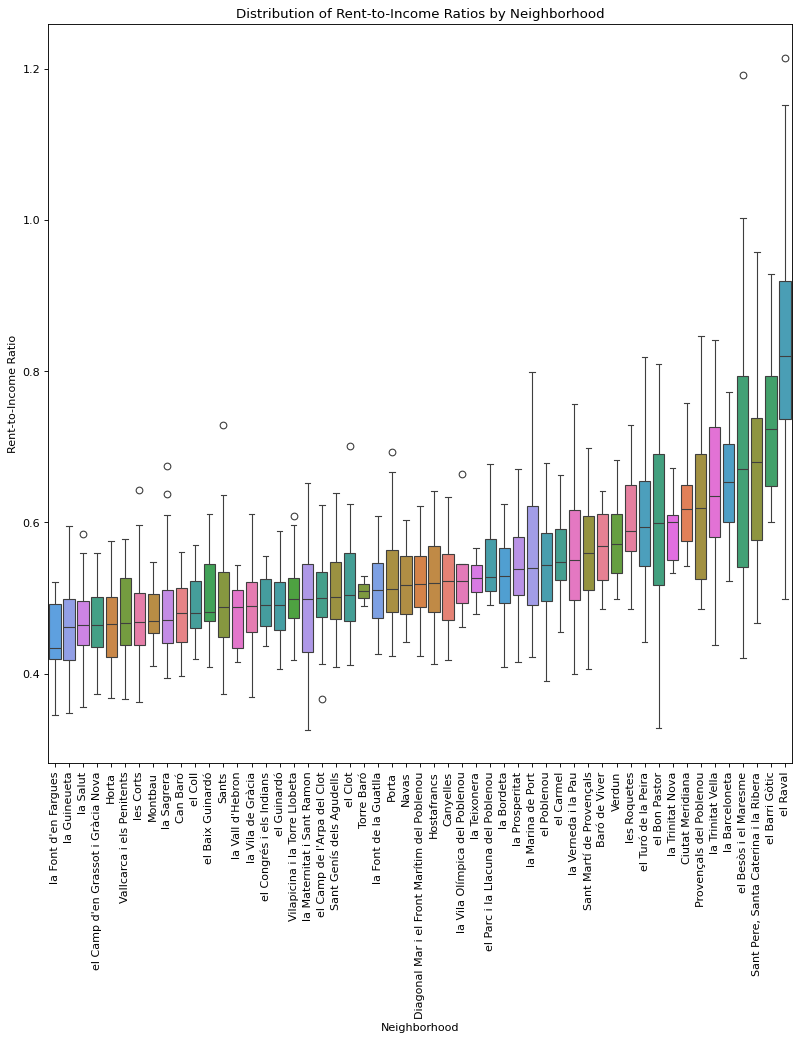

In [6]:
median_values = df.groupby('Nom_Barri')['Ratio_Lloguer_Renda'].median().sort_values().index

# Create the boxplot, ordering the neighborhoods based on the median value
plt.figure(figsize=(12, 12), dpi=80)
sns.boxplot(data=df, x="Nom_Barri", y="Ratio_Lloguer_Renda", hue="Nom_Barri", order=median_values)
plt.title("Distribution of Rent-to-Income Ratios by Neighborhood")
plt.xticks(rotation=90)
plt.ylabel("Rent-to-Income Ratio")
plt.xlabel("Neighborhood")
plt.show()

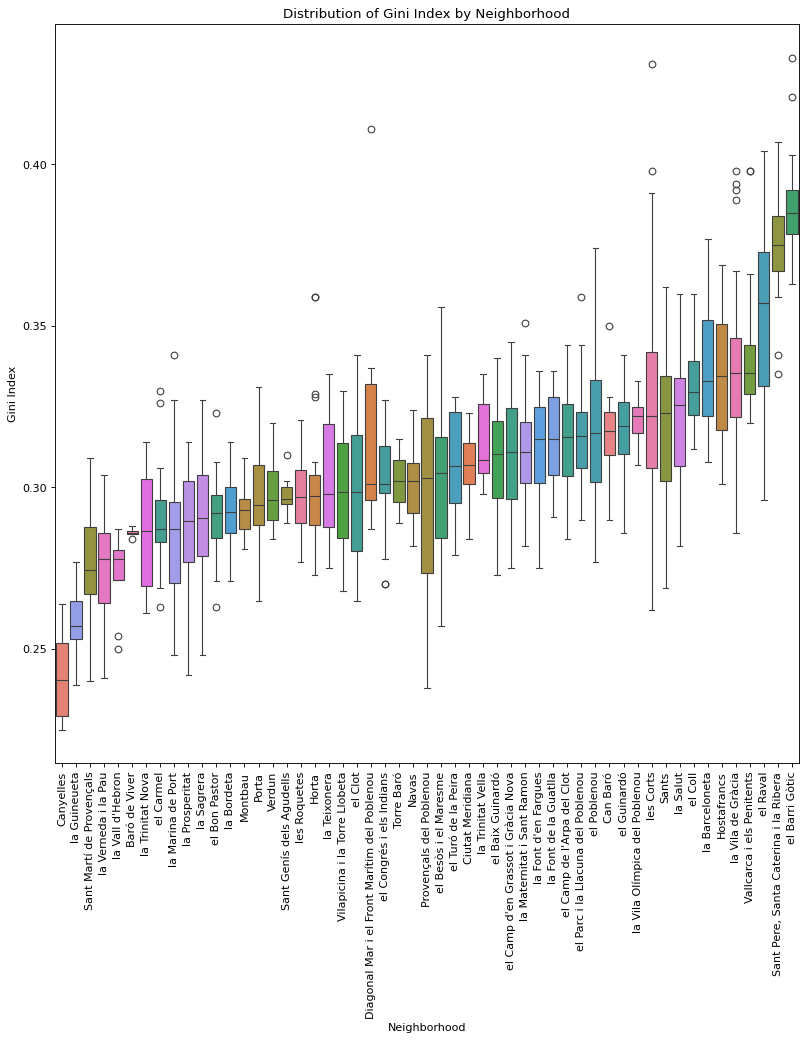

In [7]:
# Calculate the median value of index_gini for each neighborhood
median_gini = df.groupby('Nom_Barri')['Index_Gini'].median().sort_values().index

# Create the boxplot for index_gini, ordering the neighborhoods based on the median value
plt.figure(figsize=(12, 12), dpi=80)
sns.boxplot(data=df, x="Nom_Barri", y="Index_Gini", hue="Nom_Barri", order=median_gini)
plt.title("Distribution of Gini Index by Neighborhood")
plt.xticks(rotation=90)
plt.ylabel("Gini Index")
plt.xlabel("Neighborhood")
plt.show()


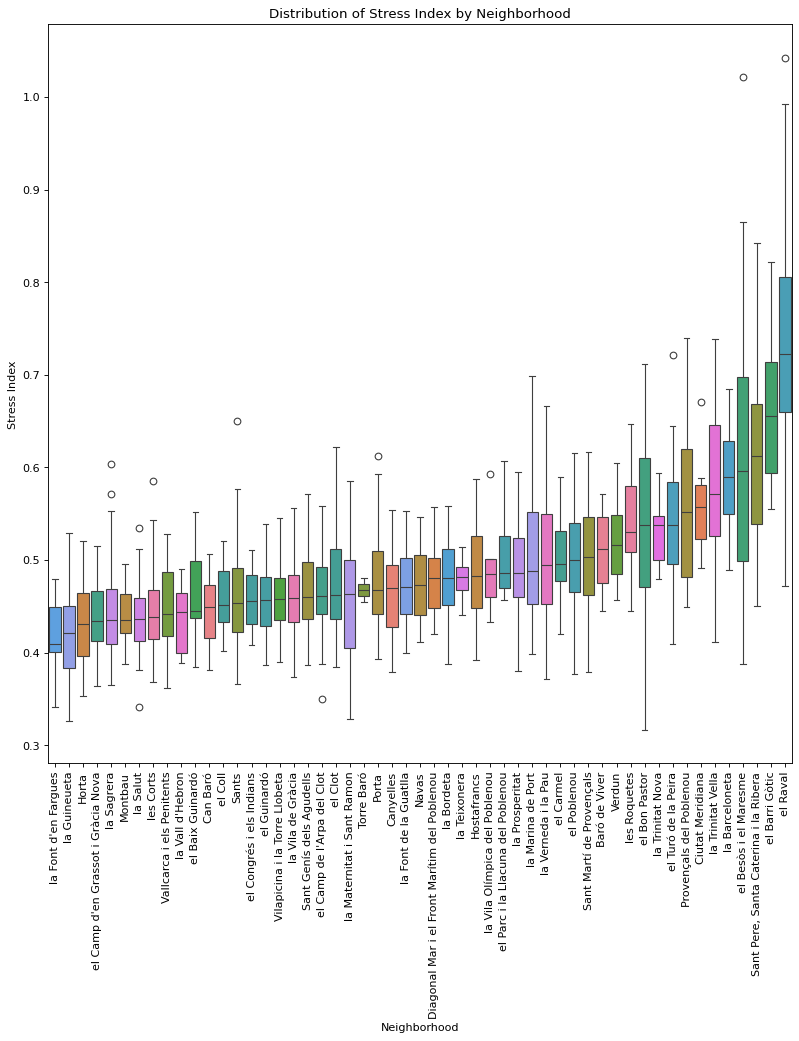

In [8]:
# Calculate the median value of estres for each neighborhood
median_estres = df.groupby('Nom_Barri')['Estres_Economic'].median().sort_values().index

# Create the boxplot for estres, ordering the neighborhoods based on the median value
plt.figure(figsize=(12, 12), dpi=80)
sns.boxplot(data=df, x="Nom_Barri", y="Estres_Economic", hue="Nom_Barri", order=median_estres)
plt.title("Distribution of Stress Index by Neighborhood")
plt.xticks(rotation=90)
plt.ylabel("Stress Index")
plt.xlabel("Neighborhood")
plt.show()


## 2.4 Proportion of Economic Stress

Below one can see the comparison between the proportion of High vs Low economic stress, which points out that around 2/3 neighborhoods of barcelona are under economic stress. Moreover, almost 84% of neighborhoods on average spend more than 45% of its income in rent.

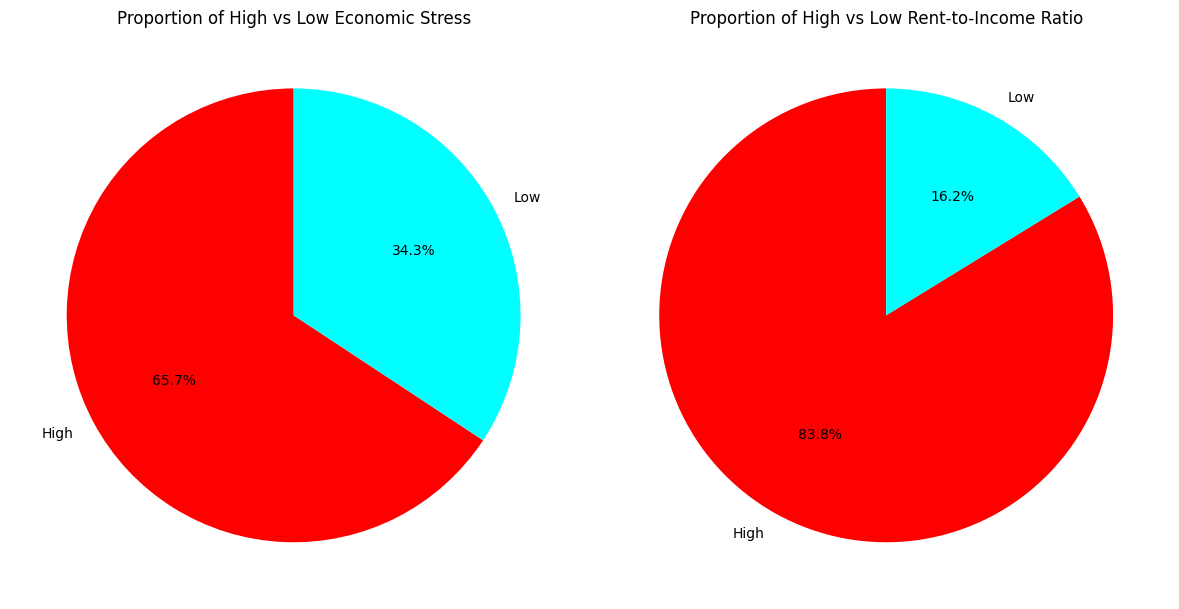

In [9]:
# Pie Chart Data
stress_counts = df['Factor_Estres'].value_counts()
ratio_counts = df['Factor_Ratio'].value_counts()

# Side-by-Side Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for Factor_Estres
axes[0].pie(
    stress_counts,
    labels=stress_counts.index,
    autopct='%1.1f%%',
    colors=["red", "cyan"],
    startangle=90
)
axes[0].set_title("Proportion of High vs Low Economic Stress")

# Pie chart for Factor_Ratio
axes[1].pie(
    ratio_counts,
    labels=ratio_counts.index,
    autopct='%1.1f%%',
    colors=["red", "cyan"],
    startangle=90
)
axes[1].set_title("Proportion of High vs Low Rent-to-Income Ratio")

plt.tight_layout()
plt.show()

## 2.5 Geographical visualization of Stress

From both plots, similar insights can easily be gathered: All the neighborhoods of barcelona included in our analysis are atleast somewhat economically stressed on average, where some of them like Barceloneta, Barri Gotic and Raval to name a few are experiencing an astonishing economic burden. The same logic can be applied to the Rent-to-Income ratio.


## 2.5.1 Prepare geographical data

In [73]:
#Aggregate datasets
estres_df = df[["Nom_Barri", "Estres_Economic"]]
estres_df = estres_df.groupby("Nom_Barri").mean().reset_index()

ratio_df = df[["Nom_Barri", "Ratio_Lloguer_Renda"]]
ratio_df = ratio_df.groupby("Nom_Barri").mean().reset_index()


# Load geo data and convert geometries
data = pd.read_json("drive/MyDrive/Assignatures/ADSDB/barcelona_barris.json")
data['geometry'] = data['geometria_wgs84'].apply(wkt.loads)
geo_data = gpd.GeoDataFrame(data, geometry='geometry')
geo_data = geo_data[["nom_barri", "geometry"]]

# Join estres_df and ratio_df with geo_data
merged = geo_data.merge(estres_df, left_on='nom_barri', right_on='Nom_Barri', how='left')
merged = merged.merge(ratio_df, on='Nom_Barri', how='left')


## 2.5.2 Stress Heatmap

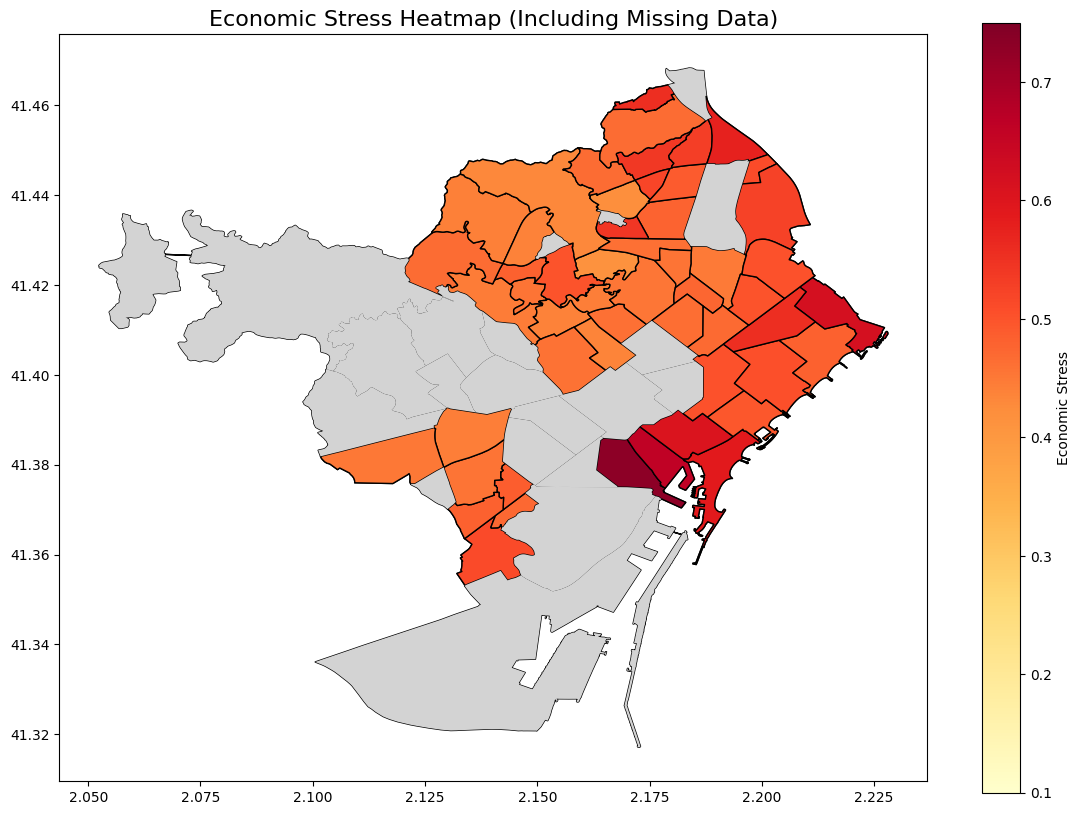

In [84]:
# Boolean placeholder
merged['has_data'] = ~merged['Estres_Economic'].isnull()

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot all neighborhoods in grey as the base layer
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', label='No Data')

# Overlay neighborhoods with data
merged[merged['has_data']].plot(
    ax=ax,
    column='Estres_Economic',
    cmap='YlOrRd',
    edgecolor='black',
    legend=True,
    vmin=0.1,
    vmax=0.75,
    legend_kwds={
        'label': "Economic Stress",
        'orientation': "vertical"
    }
)

# Add missing neighborhoods (null values) in black
merged[~merged['has_data']].plot(
    ax=ax,
    color='lightgrey',
    label='No Information'
)

# Customize plot
ax.set_title("Economic Stress Heatmap (Including Missing Data)", fontsize=16)
plt.show()


## 2.5.3 Rent-to-Income Ratio Heatmap

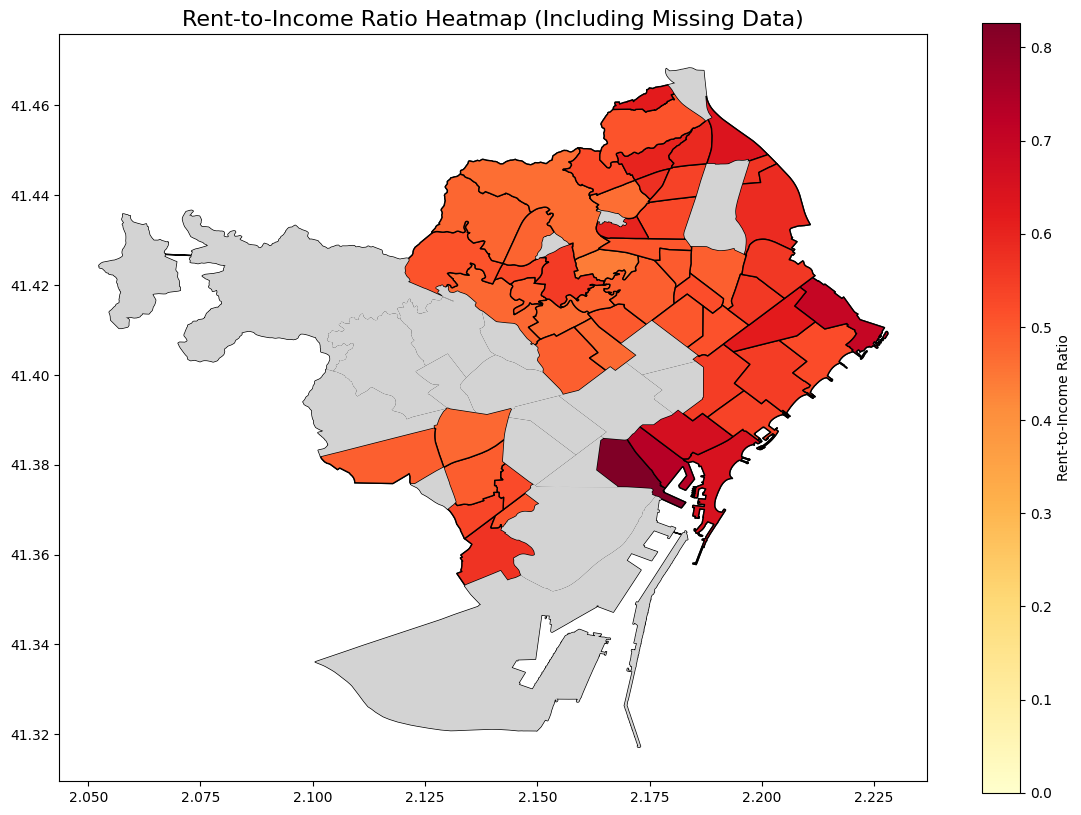

In [83]:
#Boolean placeholder
merged['has_data'] = ~merged['Ratio_Lloguer_Renda'].isnull()

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot all neighborhoods in grey as the base layer
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black', label='No Data')

# Overlay neighborhoods with data
merged[merged['has_data']].plot(
    ax=ax,
    column='Ratio_Lloguer_Renda',  # Change this to 'Ratio_Lloguer_Renda' for a different metric
    cmap='YlOrRd',
    edgecolor='black',
    legend=True,
    vmin=0.0,
    legend_kwds={
        'label': "Rent-to-Income Ratio",
        'orientation': "vertical"
    }
)

# Add missing neighborhoods (null values) in black
merged[~merged['has_data']].plot(
    ax=ax,
    color='lightgrey',
    label='No Information',
    legend=True
)

# Customize plot
ax.set_title("Rent-to-Income Ratio Heatmap (Including Missing Data)", fontsize=16)
plt.show()



# 3. Principal Component Analysis

Following up a dimensionality reduction unsupervised technique is applied in order to extract further insights. Applying scaling is crucial for avoiding issues related to scales given the nature of PCA.

**Axis and interpretation**:

1. **PC1**: is dominated by the contributions of the Income variables (Import_Renda_Bruta, Import_Renda_Disposable...) and Preu_mitja, which have a direct relationship.

2. **PC2**: is dominated by strong contributions of Economic Stress, The Rent-to-income Ratio and the inequality indicators (Gini and P80/20). Just as expected after the correlation analysis, age has a strong inverse contribution to this component.

Therefore, the higher the value of the 1st axis, the higher the income and rent and lower the economic stress  The higher the value of the 2nd axis, the higher the economic stress, inequality and average age. Note that the inverse of both statements is true. However, there not all variables have a perfect alingment with both axes, so Economic Stress is more related to the negative diagonal (2nd to 4th quadrant).

**Patterns**: Thanks to the target variable Factor_Estres and the aforementioned interpretation of the axes, we can see that there is an extremely clear division between Low and High stress neighborhoods. The upper region (and somewhat left) region of the new dimensions is associated with high economic stress neighborhoods (High Rent-to-income, High economic stress index and high Gini_Index)

The lower right section of the new plane is populated of low economic stress neighborhoods, effectively clustering wealthier areas with higher disposable income.

Although there is some overlap in the middle, it is clear that linear discriminant methods could yield great results in chategorizing this data into whether low or high economically stressed areas.


**Outliers**: In the lower left and upper right quadrants we can observe some outliers that disrupt the almost perfect linear separation between the 2 clusters (High vs Low economic stress). The latter individuals,  show atypical demography (Average and low age), high rent prices, and mildly high inequality. However this kind of observations are a really small percentage of the overall picture.

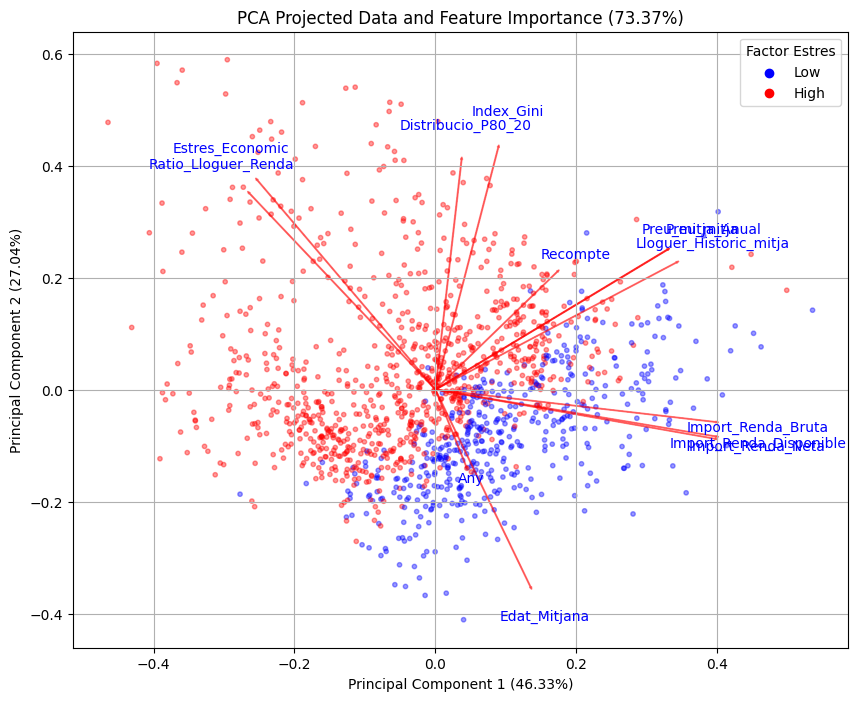

In [11]:
#Scale the input data
scaler = StandardScaler()
scaler.fit(numeric_df)
X = scaler.transform(numeric_df)

pca = PCA(n_components=2)
XX = pca.fit_transform(X)

def myplot(score, coeff, labels, ratios, binary_variable):
    """
    Plots the PCA biplot with given scores, coefficients, labels, and colors based on a binary variable.

    Parameters:
    - score: The PCA-transformed data (scores)
    - coeff: The PCA coefficients (loadings)
    - labels: List of variable names corresponding to the coefficients
    - binary_variable: A binary factor variable (e.g., Ratio_Lloguer_Renda)
    """
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    # Assign colors based on the binary variable (e.g., 0 = red, 1 = blue)
    colors = binary_variable.map({"Low": 'blue', "High": 'red'})

    plt.figure(figsize=(10, 8))

    # Plot the PCA points, colored by the binary variable
    plt.scatter(xs * scalex, ys * scaley, alpha=0.4, s=10, c=colors)

    # Add arrows and labels for the PCA loadings
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        label = labels[i] if labels else f"Var{i+1}"  # Use label if provided, else default to Var{i+1}
        plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, label, color='b', ha='center', va='center')


    plt.xlabel(f"Principal Component 1 ({100 * ratios[0]:.2f}%)")
    plt.ylabel(f"Principal Component 2 ({100 * ratios[1]:.2f}%)")
    plt.grid()
    plt.title(f"PCA Projected Data and Feature Importance ({100 * sum(ratios):.2f}%)")

    # Legend
    plt.scatter([], [], color='blue', label='Low')
    plt.scatter([], [], color='red', label='High')
    plt.legend(loc='upper right', title='Factor Estres')
    plt.show()


binary_variable = df['Factor_Estres']

myplot(XX[:, 0:2], np.transpose(pca.components_[0:2, :]), list(numeric_df.columns), ratios=pca.explained_variance_ratio_, binary_variable=binary_variable)


# 4. Clustering Analysis

One of the biggest concerns of our analysis lies in clustering the neighborhoods for identifying potential trends among them. The main aim is to categorize into smaller than only high or low economic stress, more informative aggroupations of neighbourhoods.

Two suitable clustering algorithms for this purpose would be K-means++ and Hierarchical Clustering. However, to not leave any pontential gains on the table we will perform a general quick exploration of other options, and use metrics like silhouette index, Davies-Bouldin index and visual assessement to determine the best fit for a fixed number of clusters. The value chosen in this case has been 5.

Given that the Principal Component Analysis produced a couple of new axes that achieve explaining almost 75% of variance, it would also be highly profitable to perform clustering on this plane that can easily be visualized.




## 4.1 Clustering Algorithms Comparison

After several executions of this exploration snippet, DBSCAN has obviously been discarded for its poor performance. Then after comparing through visual assessment and quantitative metrics, Agglomerative clustering using complete linkage seems to have performed the best. K-means comes second but due to the lack of elbow on the inertia plot, it does seem advisable to choose this algorithm.

Running K-Means...
Running Gaussian Mixture...
Running DBSCAN...
Running Agglomerative...

=== Clustering Metrics Comparison ===
K-Means: Silhouette = 0.35, Davies-Bouldin = 0.86
Gaussian Mixture: Silhouette = 0.35, Davies-Bouldin = 0.87
DBSCAN: Silhouette = -0.54, Davies-Bouldin = 6.26
Agglomerative: Silhouette = 0.33, Davies-Bouldin = 0.84


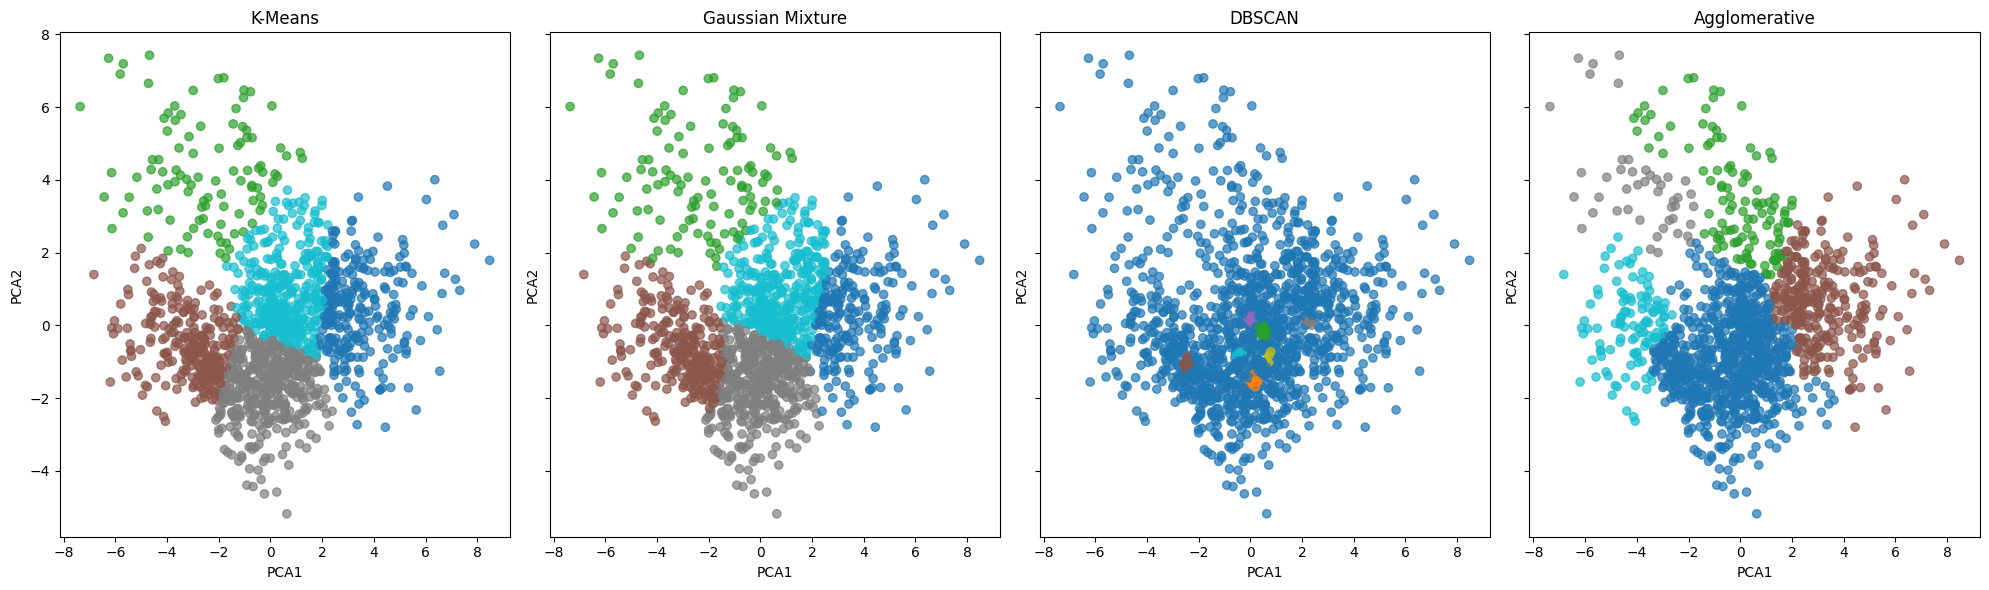

In [12]:
num_clusters = 5
linkage_method = "complete"
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000),
    'Gaussian Mixture': GaussianMixture(n_components=num_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.15, min_samples=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method),
}

# Store results for comparison
clustering_results = {}
scores = {}

for name, algo in clustering_algorithms.items():
    print(f"Running {name}...")

    if name == 'Gaussian Mixture':
        cluster_labels = algo.fit_predict(XX)
    else:
        cluster_labels = algo.fit(XX).labels_

    clustering_results[name] = cluster_labels

    silhouette = silhouette_score(XX, cluster_labels)
    db_score = davies_bouldin_score(XX, cluster_labels)
    scores[name] = {'Silhouette Score': silhouette, 'Davies-Bouldin Score': db_score}

# Compare Scores
print("\n=== Clustering Metrics Comparison ===")
for algo, metrics in scores.items():
    print(f"{algo}: Silhouette = {metrics['Silhouette Score']:.2f}, Davies-Bouldin = {metrics['Davies-Bouldin Score']:.2f}")

# Visualize Results
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)

for idx, (name, labels) in enumerate(clustering_results.items()):
    axes[idx].scatter(XX[:, 0], XX[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[idx].set_title(name)
    axes[idx].set_xlabel('PCA1')
    axes[idx].set_ylabel('PCA2')

plt.tight_layout()
plt.show()

## 4.2 Agglomerative Hierarchical Clustering

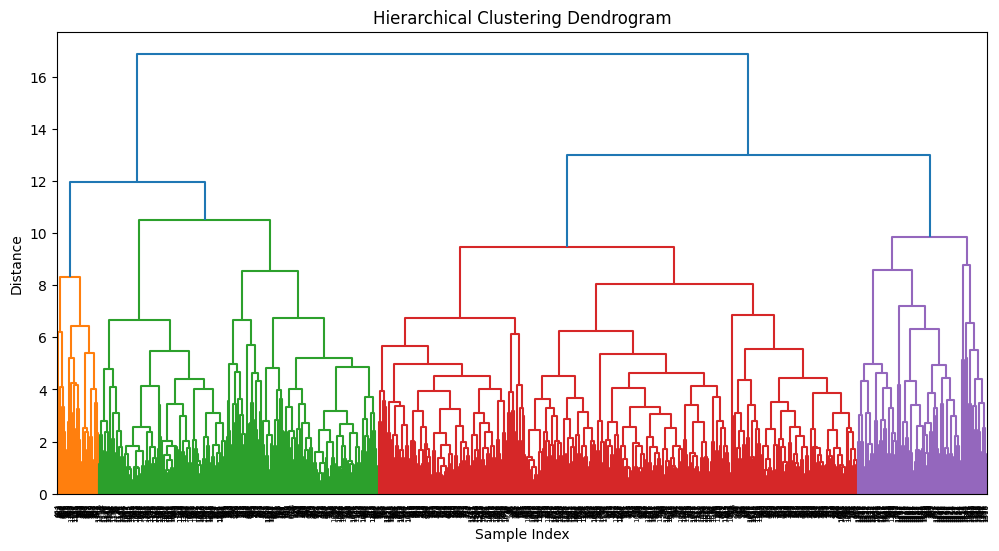

Silhouette Score for Hierarchical Clustering: 0.3286029614869477


In [13]:

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage="complete")
labels = hierarchical.fit_predict(XX)

linked = linkage(X, 'complete')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Calculate silhouette score for hierarchical clustering
silhouette_hierarchical = silhouette_score(XX, labels)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}")
df['Cluster'] = labels

## 4.3 Cluster Profiling and Analysis

Finally, an extensive profiling and analysis of the clusters yielded by the chosen algorithm will be presented, to capture trends and patterns among the clusters. To perform an easy profiling, we have somewhat replicated the FactoMineR function catdes/condes below.


**Results**:

---

### Cluster 0: Moderate-Income, Diverse Rent Prices, Older Residents
- **Income:** This cluster has a moderate income level, with average values around €18,770 (Renda Bruta) and €15,167 (Renda Neta). This is below the overall average.
- **Rent Prices:** Rent prices are relatively moderate, with an average of €787.
- **Demographics:** This cluster has the highest average age (45 years), indicating that the residents are typically older.
- **Location Preferences:** They tend to live in more varied neighborhoods, including both higher-priced and more affordable areas such as:
  - **Horta** (5.24%)
  - **Vilapicina i la Torre Llobeta** (4.74%)
  - **Navas** (3.25%)
  - **el Guinardó** (6.24%)
  - **el Camp de l'Arpa del Clot** (5.99%)
- **Other Characteristics:** This group shows average levels of income inequality (Gini index) and may include people who prioritize affordability and long-term residence.

---

### Cluster 1: Lower-Income, High Rent, Younger Residents
- **Income:** Residents have relatively lower income levels, with an average income of around €17,463 (Renda Bruta) and €14,030 (Renda Neta).
- **Rent Prices:** Rent prices in this cluster are higher compared to the first, averaging €927 per month, likely indicating that these individuals live in neighborhoods with higher rental prices.
- **Demographics:** This cluster has younger residents (average age: 40.7 years).
- **Location Preferences:** They prefer more central and trendy areas like:
  - **Sant Pere, Santa Caterina i la Ribera** (20.18%)
  - **el Raval** (12.28%)
  - **el Poblenou** (13.16%)
  - **la Vila Olímpica del Poblenou** (1.64%)
  - **la Vila de Gràcia** (8.77%)
- **Other Characteristics:** Higher levels of income inequality (Index Gini of ~0.36) might suggest some socio-economic disparity within this group.

---

### Cluster 2: High-Income, High Rent, Diverse Neighborhoods
- **Income:** This cluster has the highest income levels, with an average of €25,520 (Renda Bruta) and €19,685 (Renda Neta), well above the overall average.
- **Rent Prices:** Rent prices are also on the higher end, averaging €967, aligning with their higher income.
- **Demographics:** This group has a mix of ages but tends to be slightly younger (average age: 44.3 years).
- **Location Preferences:** Members of this cluster live in more diverse neighborhoods, often those with high demand and higher rent, like:
  - **Vila de Gràcia** (20.39%)
  - **Les Corts** (21.05%)
  - **el Camp d'en Grassot i Gràcia Nova** (14.80%)
  - **el Parc i la Llacuna del Poblenou** (4.28%)
- **Other Characteristics:** A moderately high Gini index (0.32) suggests some income inequality within this group, but they generally have strong financial capabilities.

---

### Cluster 3: Low-Income, Affordable Rent, Younger Residents
- **Income:** This cluster has the lowest income levels, with an average of €11,183 (Renda Bruta) and €9,549 (Renda Neta), indicating lower affordability.
- **Rent Prices:** Rent prices in this group are relatively affordable at an average of €796, aligning with their lower income.
- **Demographics:** The group is younger on average (38.9 years), suggesting that these residents might be early-career or students.
- **Location Preferences:** They tend to live in more affordable or less central neighborhoods such as:
  - **el Besòs i el Maresme** (17.78%)
  - **el Raval** (62.22%)
  - **la Trinitat Vella** (6.36%)
  - **la Marina de Port** (5.45%)
- **Other Characteristics:** The Gini index is moderate (0.34), showing some degree of income inequality. This group likely prioritizes affordability in housing.

---

### Cluster 4: Low-Income, Low Rent, Older Residents
- **Income:** This cluster has low income levels, with an average of €11,607 (Renda Bruta) and €10,105 (Renda Neta).
- **Rent Prices:** Rent prices are the lowest, averaging €650, indicating that they typically live in cheaper areas.
- **Demographics:** Residents in this cluster are somewhat older (average age: 41.7 years) compared to Cluster 3 but still younger than Cluster 0.
- **Location Preferences:** They typically live in less desirable or suburban neighborhoods with lower rent prices such as:
  - **Verdun** (8.18%)
  - **el Turó de la Peira** (10.00%)
  - **la Teixonera** (2.00%)
  - **la Verneda i la Pau** (4.55%)
  - **Ciutat Meridiana** (10.91%)
- **Other Characteristics:** They have the lowest level of income inequality (Index Gini ~0.30), which may indicate a more equal distribution of wealth within this group.




In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency

def profile_variables_by_cluster(dataset, column_names, cluster_column):
    """
    Profile multiple variables in the dataset and compare them across clusters.

    Parameters:
    - dataset: pd.DataFrame
    - column_names: list of str (The names of the variables to profile)
    - cluster_column: str (The name of the cluster column)

    Returns:
    - profiles: dict of profiling results for each column
    """
    profiles = {}

    # Ensure the column names and cluster column exist in the dataset
    for column_name in column_names:
        if column_name not in dataset.columns:
            raise ValueError(f"Column '{column_name}' not found in the dataset.")
    if cluster_column not in dataset.columns:
        raise ValueError(f"Cluster column '{cluster_column}' not found in the dataset.")

    for column_name in column_names:
        profile = {}
        col_data = dataset[column_name]
        clusters = dataset[cluster_column].unique()

        if pd.api.types.is_numeric_dtype(col_data):
            # Numerical profiling
            profile['type'] = 'numerical'
            profile['n_nulls'] = col_data.isnull().sum()
            profile['overall_mean'] = col_data.mean()
            profile['overall_std_dev'] = col_data.std()

            # Compare clusters using ANOVA
            cluster_data = [dataset[dataset[cluster_column] == cluster][column_name].dropna() for cluster in clusters]
            anova_result = f_oneway(*cluster_data)
            profile['anova'] = {
                'F_statistic': anova_result.statistic,
                'p_value': anova_result.pvalue
            }

            # Mean and standard deviation per cluster
            profile['cluster_means'] = dataset.groupby(cluster_column)[column_name].mean().to_dict()
            profile['cluster_std_devs'] = dataset.groupby(cluster_column)[column_name].std().to_dict()

            # Distribution Plot
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=cluster_column, y=column_name, data=dataset)
            plt.title(f'{column_name} Distribution by {cluster_column}')
            plt.xlabel(cluster_column)
            plt.ylabel(column_name)
            plt.grid()
            plt.show()

        elif pd.api.types.is_categorical_dtype(col_data) or pd.api.types.is_object_dtype(col_data):
            # Categorical profiling
            profile['type'] = 'categorical'
            profile['n_nulls'] = col_data.isnull().sum()
            profile['unique_values'] = col_data.nunique()
            profile['top_value_overall'] = col_data.mode()[0]
            profile['top_value_count_overall'] = col_data.value_counts().max()

            # Frequency distribution by cluster
            freq_by_cluster = dataset.groupby(cluster_column)[column_name].value_counts(normalize=True).unstack(fill_value=0)
            profile['frequency_distribution_by_cluster'] = freq_by_cluster

            # Chi-squared test
            contingency_table = pd.crosstab(dataset[cluster_column], dataset[column_name])
            chi2_result = chi2_contingency(contingency_table)
            profile['chi_squared'] = {
                'chi2_statistic': chi2_result[0],
                'p_value': chi2_result[1],
                'degrees_of_freedom': chi2_result[2],
                'expected_frequencies': chi2_result[3]
            }

            # Bar Plot
            plt.figure(figsize=(12, 6))
            freq_by_cluster.plot(kind='bar', stacked=True, figsize=(12, 6))
            plt.title(f'{column_name} Distribution by {cluster_column}')
            plt.xlabel(cluster_column)
            plt.ylabel('Proportion')
            plt.legend(title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid()
            plt.tight_layout()
            plt.show()

        else:
            raise ValueError(f"Column '{column_name}' is neither numerical nor categorical.")

        # Store the profile of the variable
        profiles[column_name] = profile

    return profiles


<Figure size 1200x600 with 0 Axes>

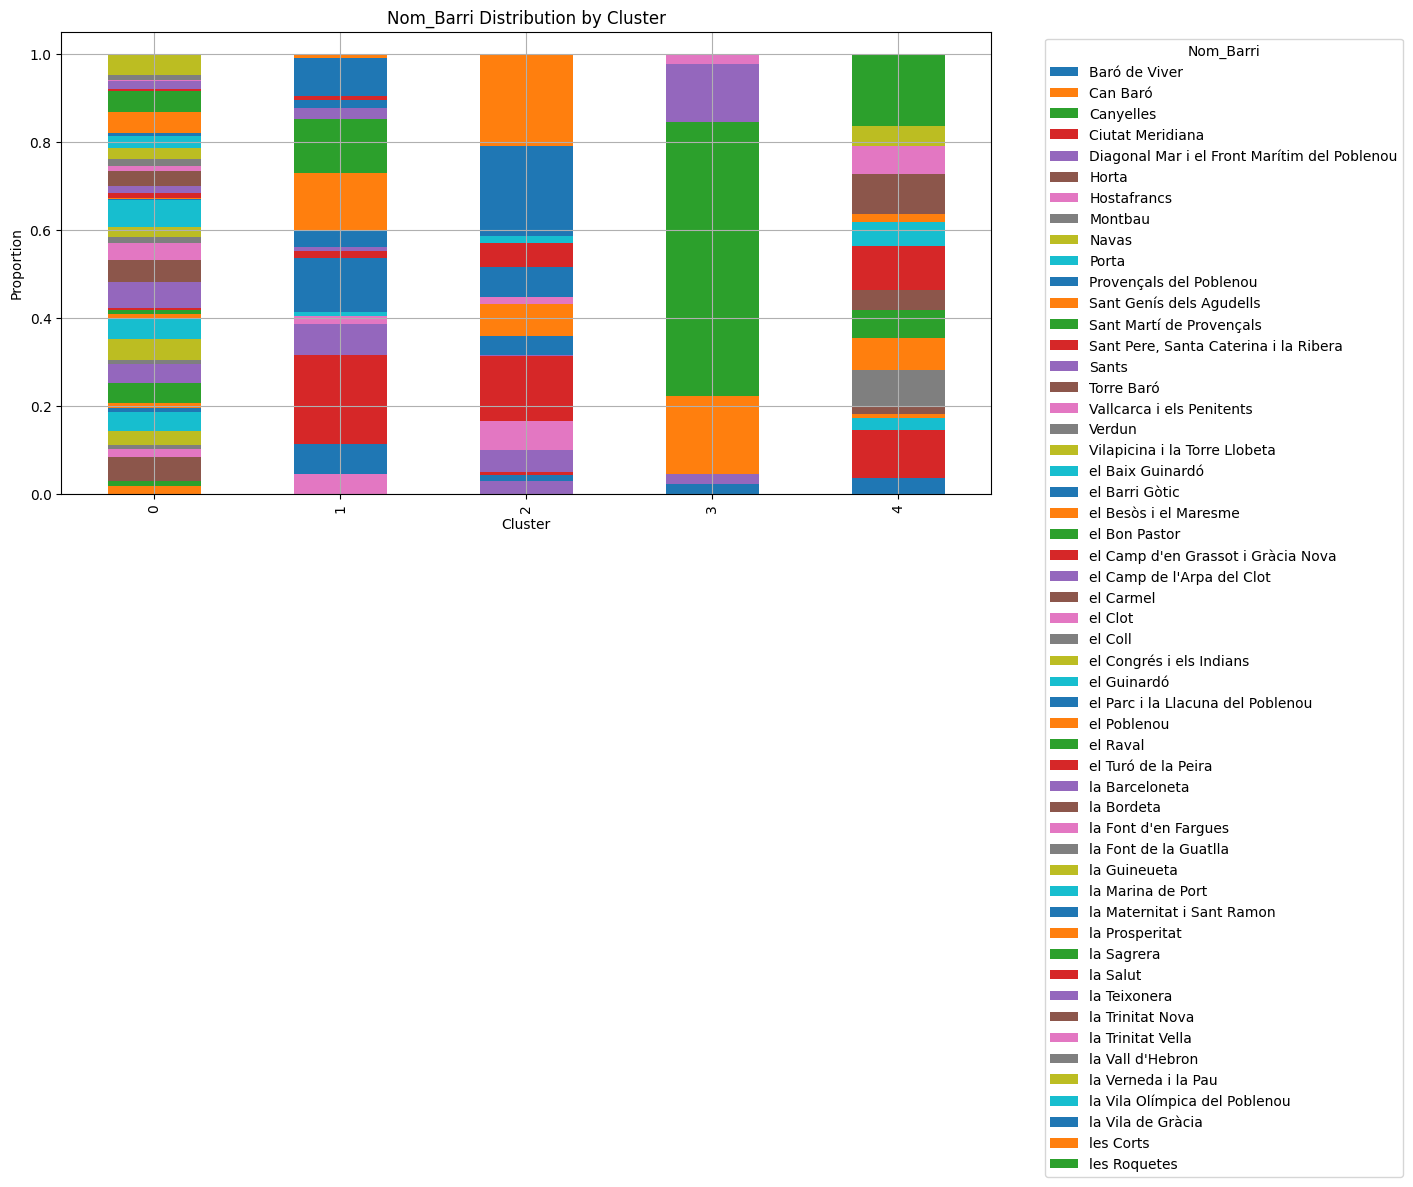

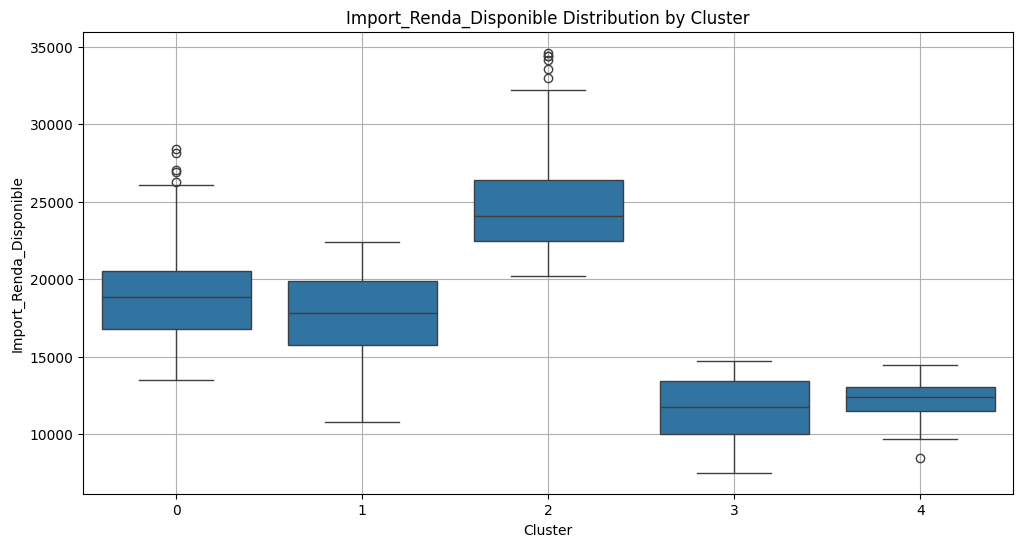

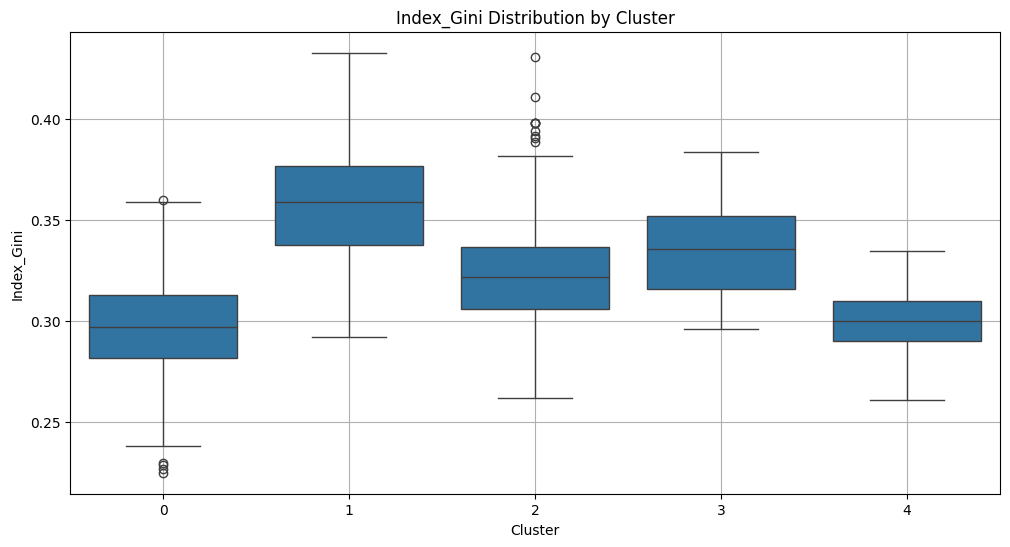

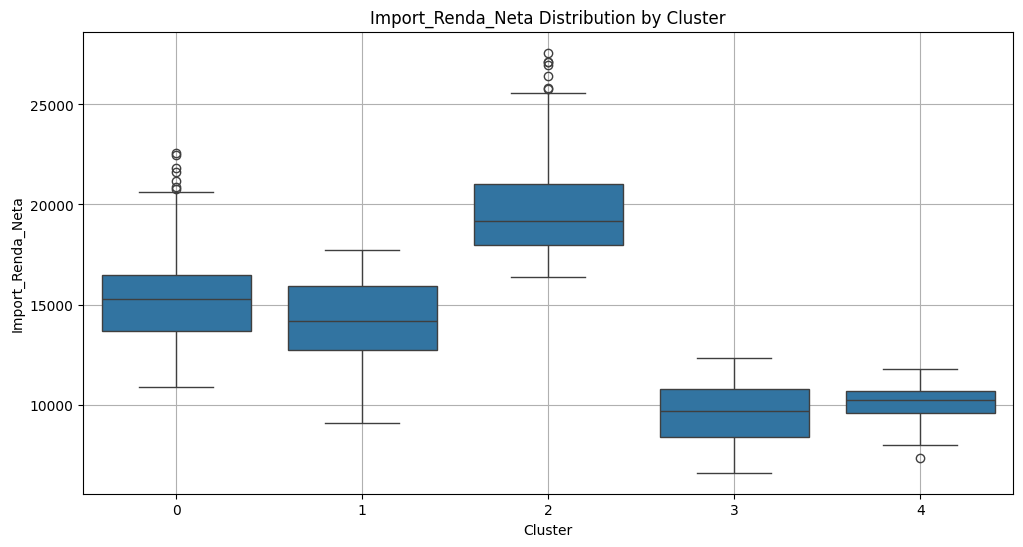

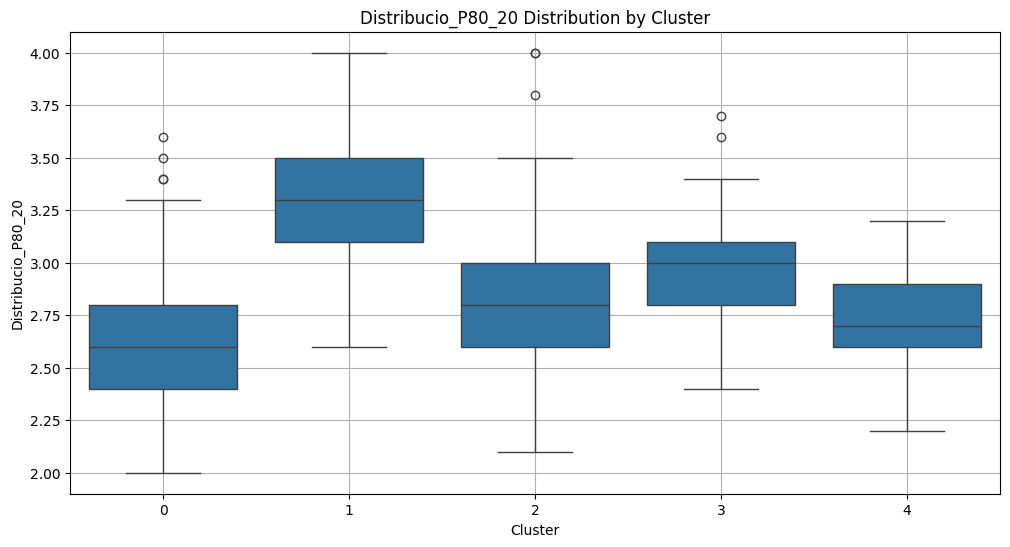

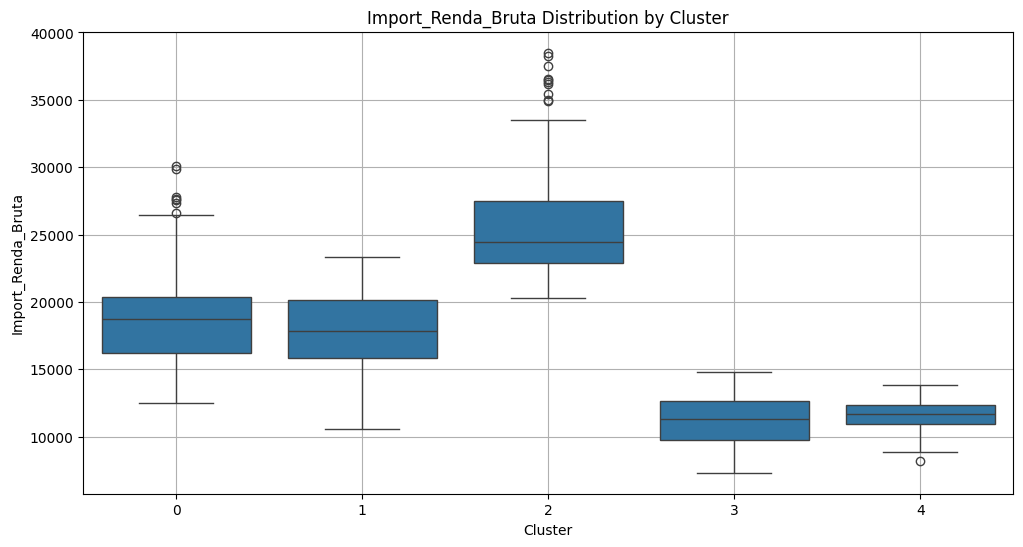

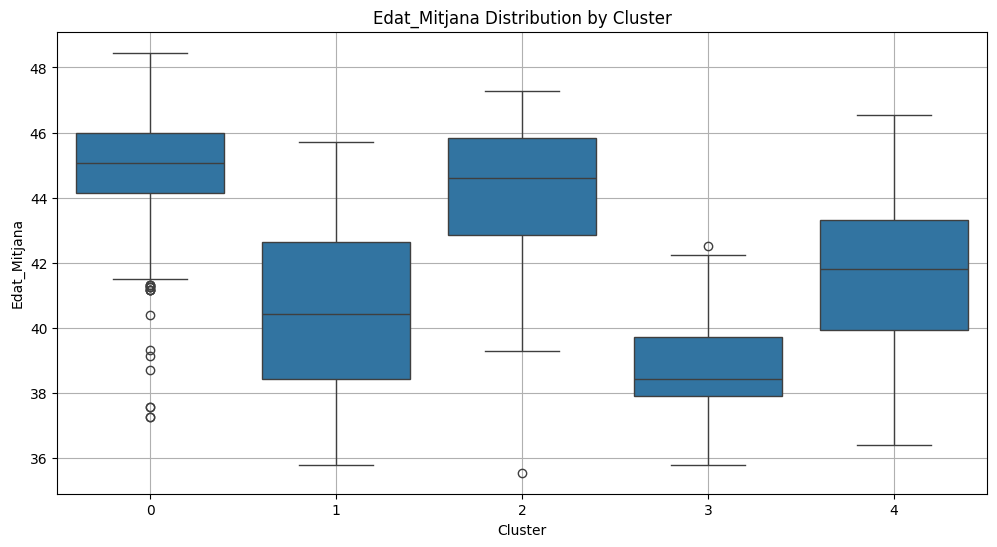

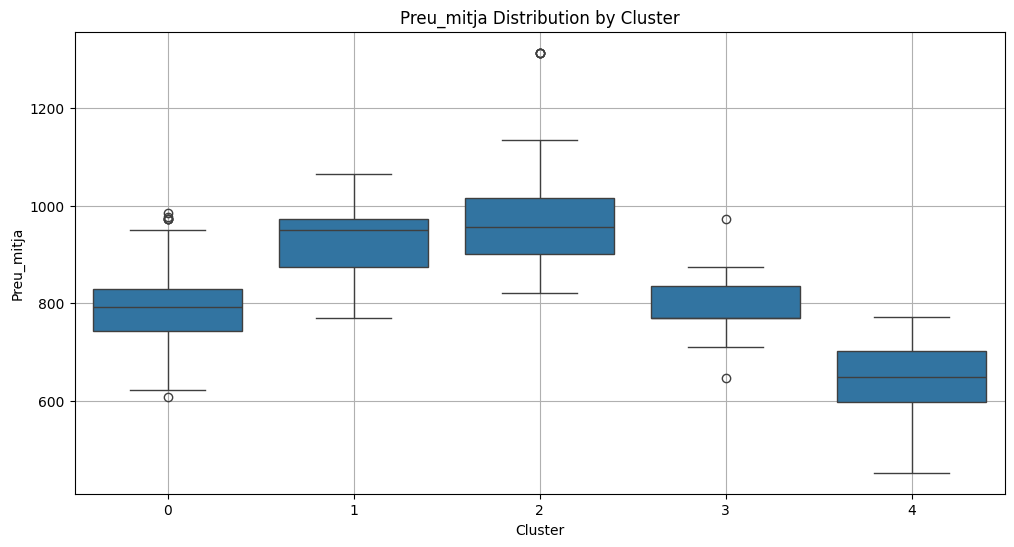

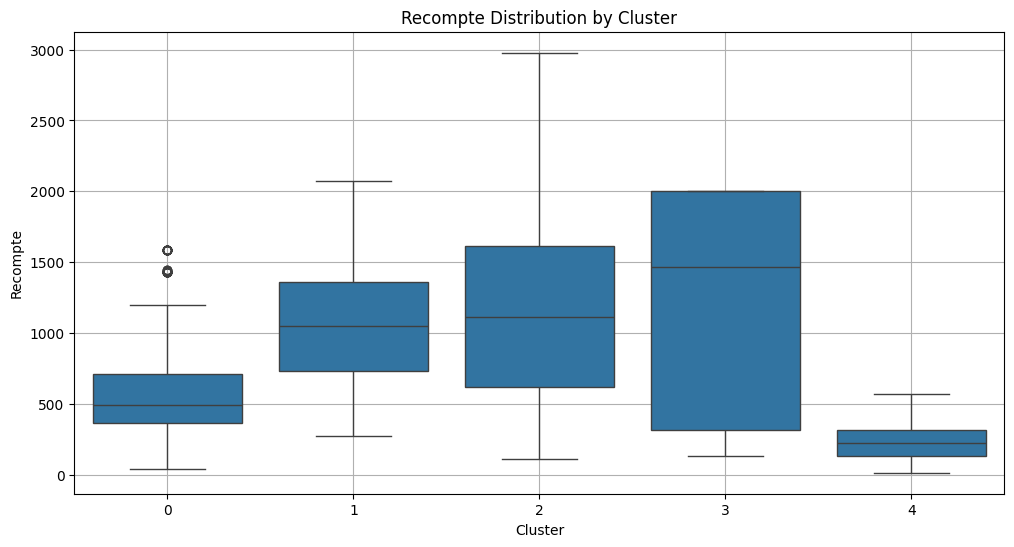

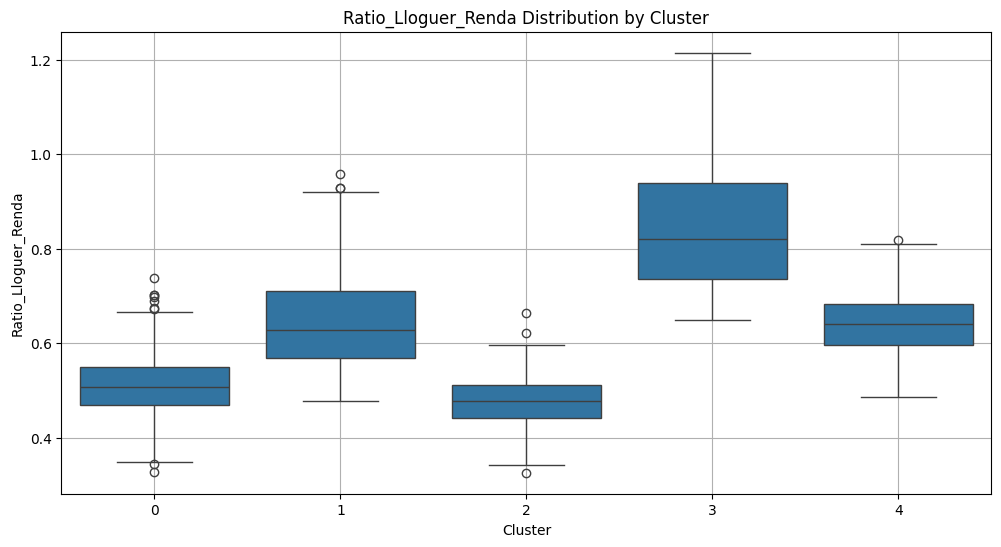

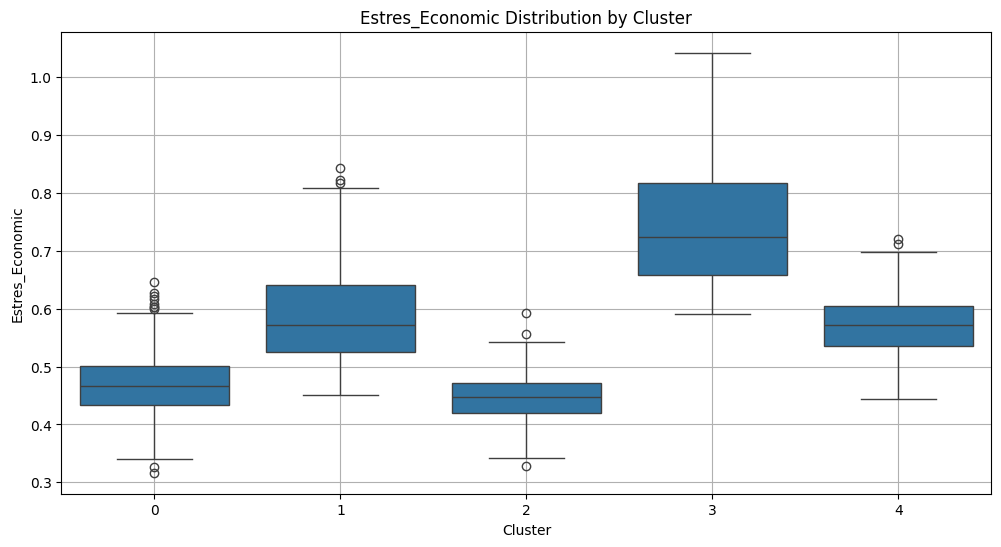

<Figure size 1200x600 with 0 Axes>

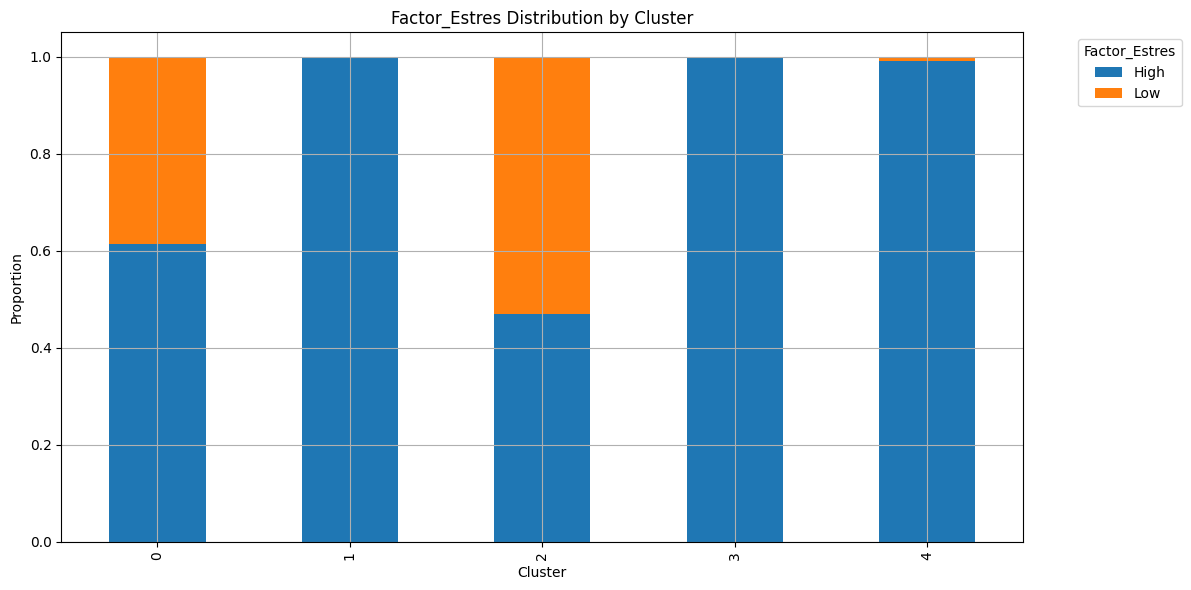

<Figure size 1200x600 with 0 Axes>

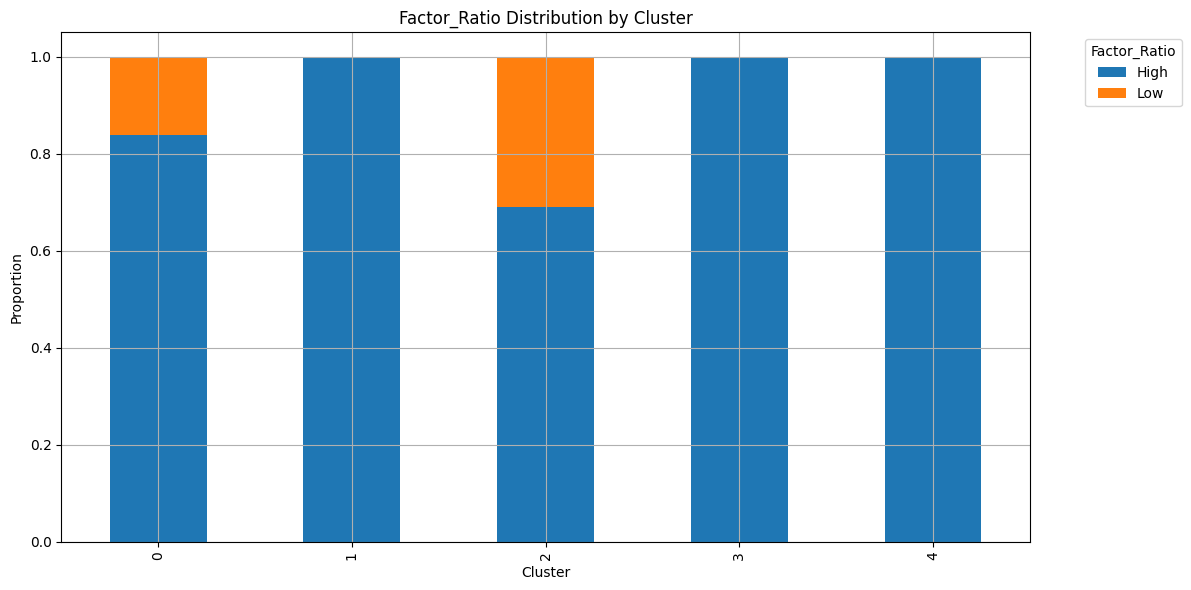

{'Nom_Barri': {'type': 'categorical',
  'n_nulls': 0,
  'unique_values': 53,
  'top_value_overall': 'la Vila de Gràcia',
  'top_value_count_overall': 72,
  'frequency_distribution_by_cluster': Nom_Barri  Baró de Viver  Can Baró  Canyelles  Ciutat Meridiana  \
  Cluster                                                           
  0               0.000000  0.017478   0.012484          0.000000   
  1               0.000000  0.000000   0.000000          0.000000   
  2               0.000000  0.000000   0.000000          0.000000   
  3               0.000000  0.000000   0.000000          0.000000   
  4               0.036364  0.000000   0.000000          0.109091   
  
  Nom_Barri  Diagonal Mar i el Front Marítim del Poblenou     Horta  \
  Cluster                                                             
  0                                              0.000000  0.052434   
  1                                              0.000000  0.000000   
  2                                    

In [15]:
profile_variables_by_cluster(df, column_names=["Nom_Barri", "Import_Renda_Disponible", "Index_Gini", "Import_Renda_Neta", "Distribucio_P80_20", "Import_Renda_Bruta", "Edat_Mitjana", "Preu_mitja", "Recompte", "Ratio_Lloguer_Renda", "Estres_Economic", "Factor_Estres", "Factor_Ratio"], cluster_column='Cluster')

## 4.4 Summary

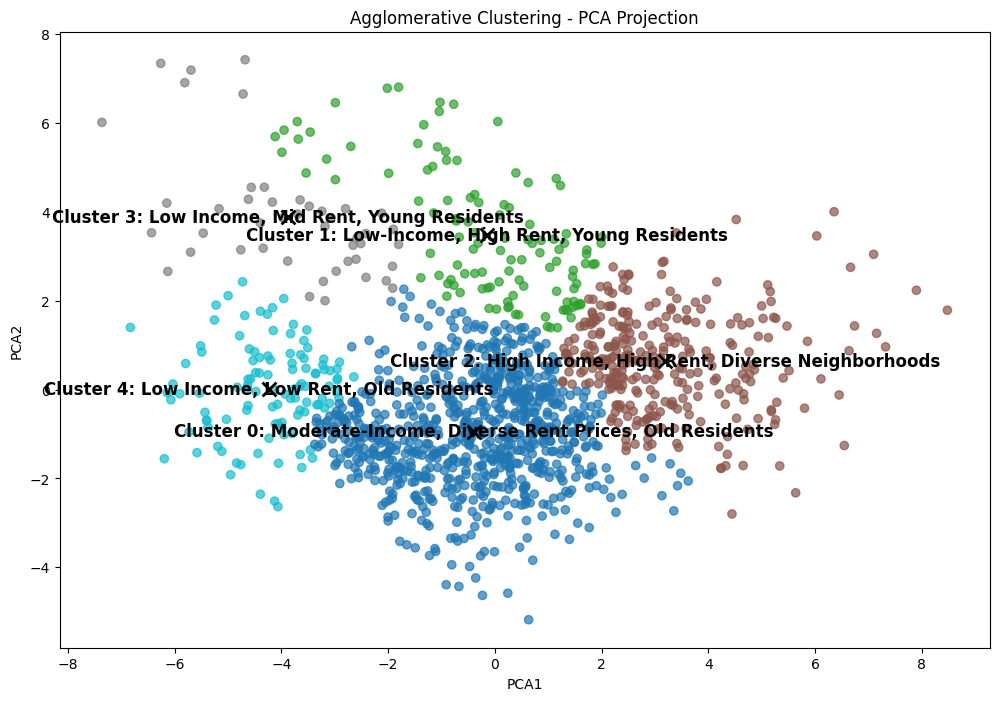

In [47]:
# Plotting the results for Agglomerative Clustering
num_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage="complete")
agg_labels = agg_clustering.fit_predict(XX)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(XX[:, 0], XX[:, 1], c=agg_labels, cmap='tab10', alpha=0.7)

# Labeling clusters with markers
titles = ["Cluster 0: Moderate-Income, Diverse Rent Prices, Old Residents",
          "Cluster 1: Low-Income, High Rent, Young Residents",
          "Cluster 2: High Income, High Rent, Diverse Neighborhoods",
          "Cluster 3: Low Income, Mid Rent, Young Residents",
          "Cluster 4: Low Income, Low Rent, Old Residents"]

for i in range(num_clusters):
    # Calculate the mean position for each cluster
    cluster_center_x = np.mean(XX[agg_labels == i, 0])
    cluster_center_y = np.mean(XX[agg_labels == i, 1])

    # Add a marker
    plt.scatter(cluster_center_x, cluster_center_y, color='black', marker='x', s=100, edgecolor='white', linewidth=2)

    # Add the text label
    plt.text(cluster_center_x, cluster_center_y, titles[i],
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12,
             color='black',
             weight='bold')

plt.title('Agglomerative Clustering - PCA Projection')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()
